In [1]:
%load_ext autoreload
%autoreload 2
from laplace.baselaplace import FullLaplace
from laplace.curvature.backpack import BackPackGGN
import numpy as np
import torch

from laplace import Laplace, marglik_training
import torch
from torchvision import datasets, transforms
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import torchvision
from netcal.metrics import ECE
from laplace.utils import ModuleNameSubnetMask

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

import torch.nn as nn

import torch.nn.functional as F
import sys
import os
import seaborn as sns
from torchsummary import summary
from pylab import rcParams
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
%matplotlib inline
sns.set_style('darkgrid')
sns.set(font_scale=1.5)

sns.set(style='darkgrid', palette='muted', font_scale=1.5)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

In [3]:
py_file_location = "/Users/georgioszefkilis/Bayesian_Deep_Learning/src/utils"
sys.path.append(os.path.abspath(py_file_location))

In [4]:
py_file_location_src = "/Users/georgioszefkilis/Bayesian_Deep_Learning/src/data"
sys.path.append(os.path.abspath(py_file_location_src))

In [5]:
import make_dataset
import AffineTransform
from AffineTransform import make_affine_parameters
import compute_dim
from compute_dim import compute_conv_dim,compute_pool_dim
import SaveLoad
from SaveLoad import save_ckp
#from src.models.STN_seq import Net
from src.models.SpatialTN_2 import Net
from src.utils import visualization
from src.utils import laplace_checks

In [6]:
if torch.cuda.is_available():
      print("The code will run on GPU.")
else:
      print("The code will run on CPU.")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

The code will run on CPU.


In [7]:
config={
            "batch_size": 100,
            "num_classes": 10,
            "channels": 1,
            "filter1_out": 16,
            "kernel_size": 5,
            "pool": 2,
            "filter2_out": 32,
            "padding": 0,
            "stride": 1,
            "learning_rate_base": 0.001,
            "learning_rate_stn":0.0001,
            "epochs": 5,
            "crop_size": 128,
            "enc_sizes":[16,32],
            "loc_sizes":[8,10],
        }


In [214]:
train_loader,valid_loader,test_loader = make_dataset.data(config["batch_size"],config["crop_size"],train_subset=10,misplacement=False,load=True,save=False,subset=True)

Getting MNIST
Train_data 100
Validation_data 17970
Test_data 10000


In [8]:
model = Net(
        config["channels"],
        config["enc_sizes"],
        config["loc_sizes"],
        config["kernel_size"],
        config["padding"],
        config["num_classes"],
        parameterize=False).to(device).eval()

In [216]:
#model_path = '/Users/georgioszefkilis/Bayesian_Deep_Learning/saved_models/STN_seq_misMNIST_10_HPC.pth'

#MNIST STN
#model_path = '/Users/georgioszefkilis/Bayesian_Deep_Learning/saved_models/colab_best_MNIST_20_STN2__ver_2lr.pth'

model_path ='/Users/georgioszefkilis/Bayesian_Deep_Learning/saved_models/STN_MNIST_100_CPU.pth'

checkpoint = torch.load(model_path, map_location=device)
    # initialize state_dict from checkpoint to model
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [260]:
sub_la,_ = laplace_checks.laplace(model,train_loader,method = 'sub',module=['stn.fc_loc.0'])


In [218]:
acc_map,ece_map,nll_map,map_images,labels = laplace_checks.predict(test_loader,model,laplace=False)
print(
        f"[MAP] Acc.: {acc_map:.1%}; ECE: {ece_map:.1%}; NLL: {nll_map:.3}"
    )


[MAP] Acc.: 55.7%; ECE: 37.5%; NLL: 1.87


In [219]:
acc_sub,ece_sub,nll_sub,sub_la_images,_ = laplace_checks.predict(test_loader,sub_la,laplace=True)
print(
        f"[Sub Network Laplace] Acc.: {acc_sub:.1%}; ECE: {ece_sub:.1%}; NLL: {nll_sub:.3}"
    )

[Sub Network Laplace] Acc.: 55.8%; ECE: 37.6%; NLL: 1.87


### GridCV research on prior precision

In [45]:
subnetwork_acc =[]
subnetwork_ece = []
subnetwork_nll =[]
prior_pre = [5,10,15,20,25,30]
for i in range(len(prior_pre)):
    sub_la.prior_precision = prior_pre[i]
    acc_sub,ece_sub,nll_sub,sub_la_images,_ = laplace_checks.predict(test_loader,sub_la,laplace=True)
    
    subnetwork_acc.append(acc_sub)
    subnetwork_ece.append(ece_sub)
    subnetwork_nll.append(nll_sub)
    print(
        f"[Sub Network Laplace] Acc.: {acc_sub:.1%}; ECE: {ece_sub:.1%}; NLL: {nll_sub:.3}"
    )

[Sub Network Laplace] Acc.: 99.0%; ECE: 3.4%; NLL: 0.0614
[Sub Network Laplace] Acc.: 99.1%; ECE: 1.6%; NLL: 0.0408
[Sub Network Laplace] Acc.: 99.1%; ECE: 1.0%; NLL: 0.0336
[Sub Network Laplace] Acc.: 99.1%; ECE: 0.7%; NLL: 0.03
[Sub Network Laplace] Acc.: 99.1%; ECE: 0.7%; NLL: 0.0279
[Sub Network Laplace] Acc.: 99.2%; ECE: 0.5%; NLL: 0.0264


In [18]:
uncertain_images = laplace_checks.uncertainties(test_loader,sub_la_images,map_images)

In [19]:
len(uncertain_images)

4357

In [20]:
test_images= []
for x,_ in test_loader:
    x = x.to(device)
    test_images.append(x)
    
test = torch.cat(test_images).cpu()

In [21]:
preds= sub_la.predictive_samples(test,pred_type='nn',n_samples=100)

la predictive samples nn


# Images with uncertainties

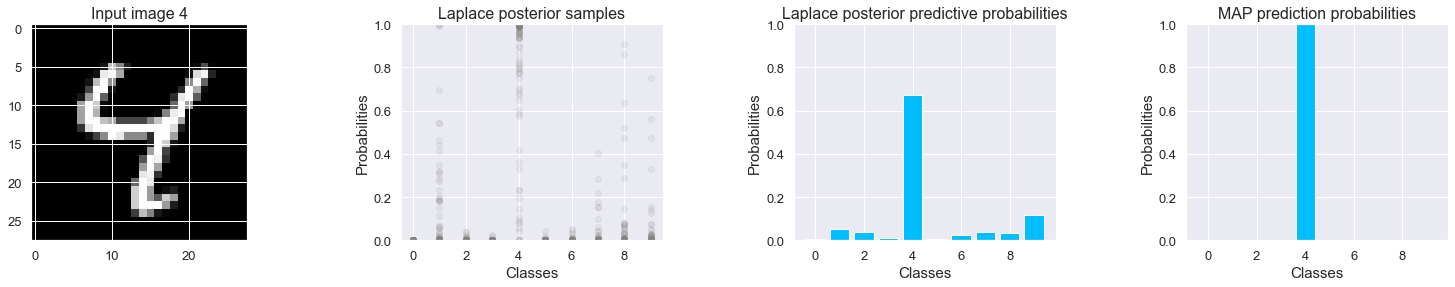

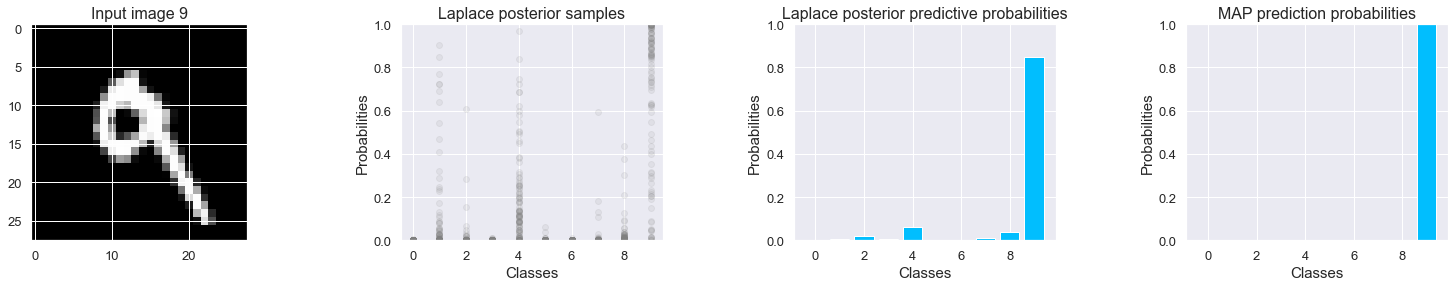

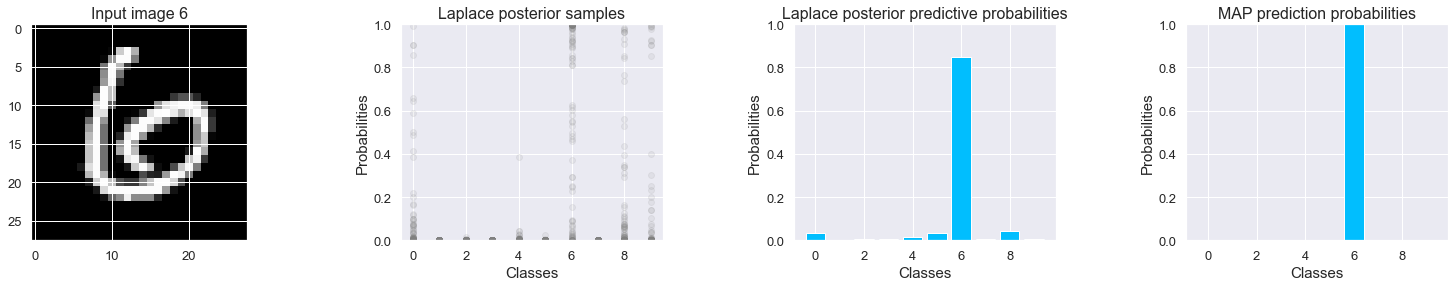

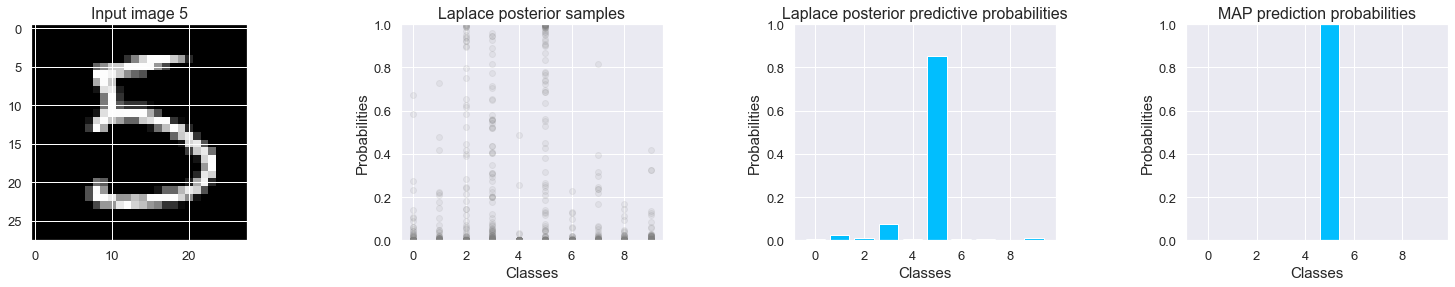

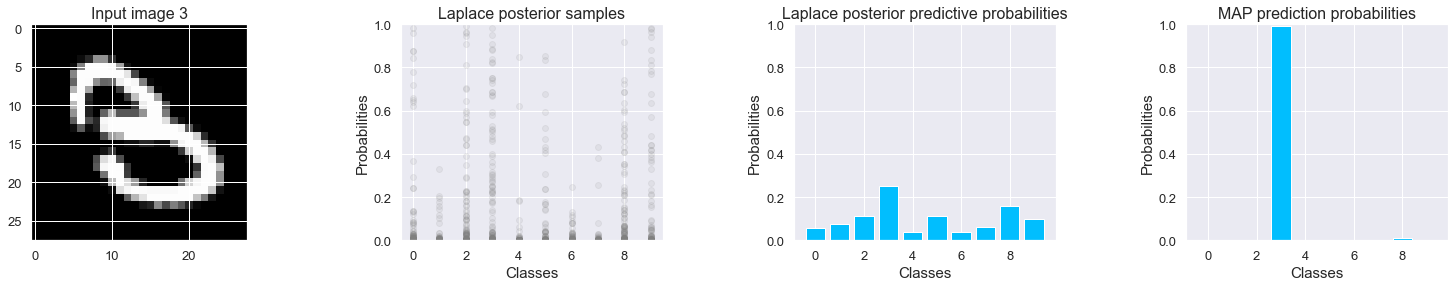

In [22]:
visualization.visualise_samples(uncertain_images,test_loader,test,labels,preds,sub_la_images,map_images)

# Images MAP  misclassified

In [23]:
misclassified_images = []
for i in range(len(test_loader.dataset)):
    vla,pla = torch.max(sub_la_images[i],-1)
    v,p= torch.max(map_images[i],-1)
    if (p != labels[i]):
        misclassified_images.append(i)


In [24]:
len(misclassified_images)

62

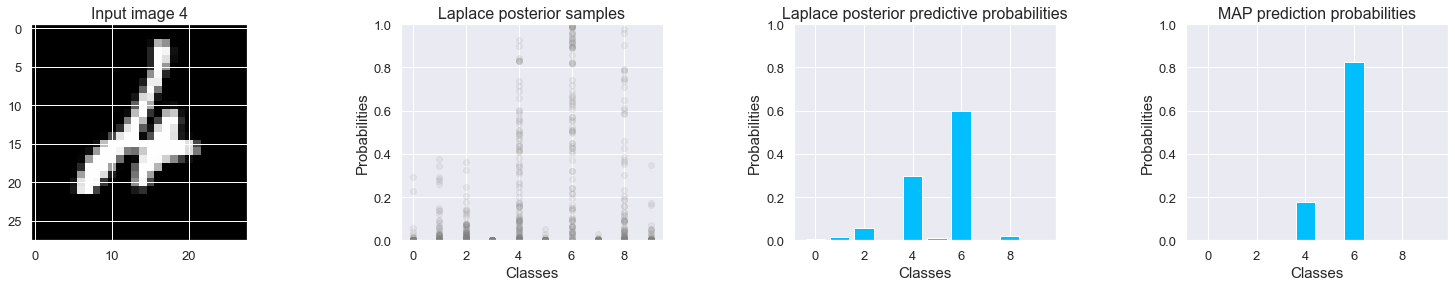

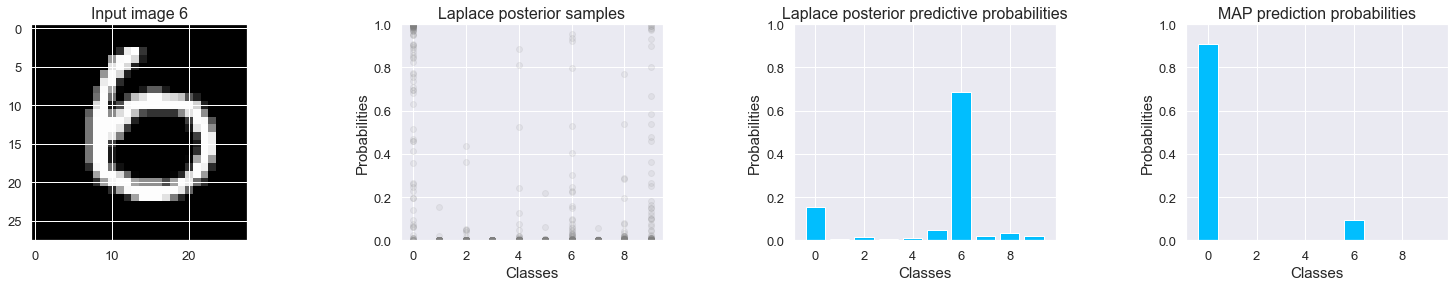

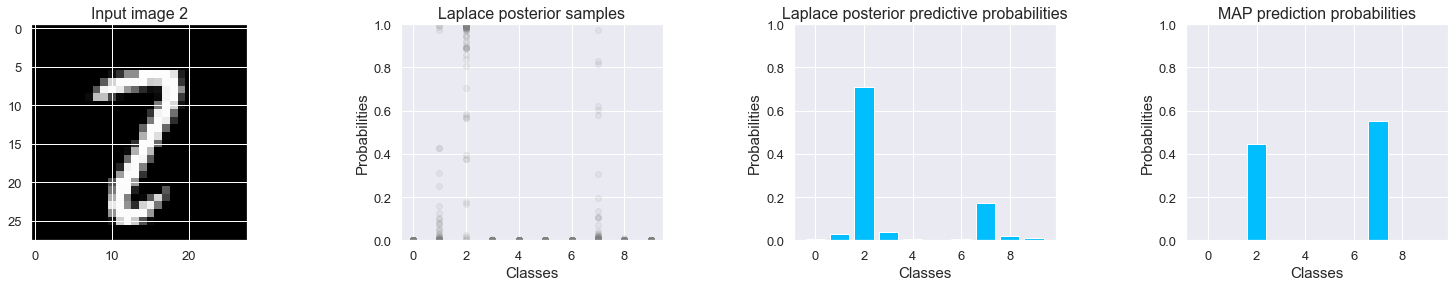

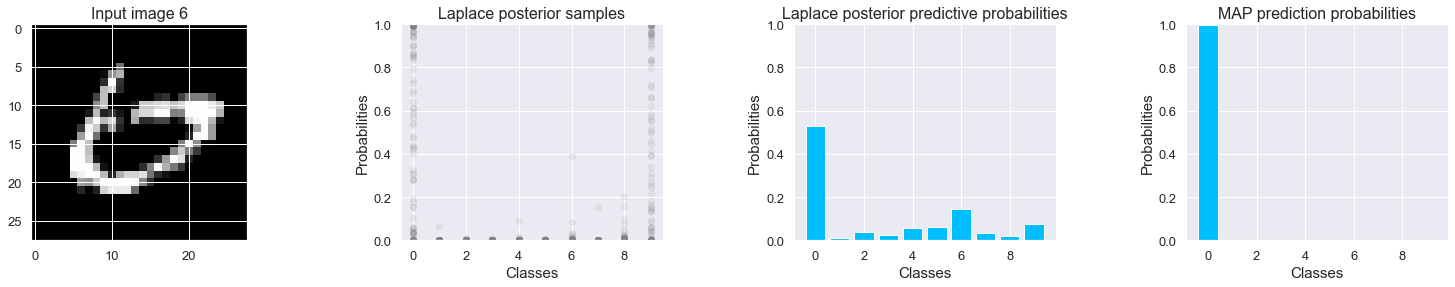

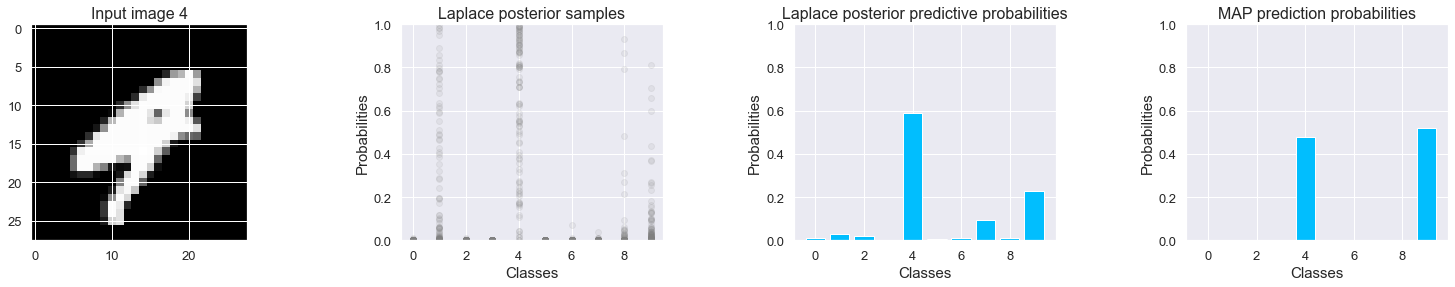

In [25]:
visualization.visualise_samples(misclassified_images,test_loader,test,labels,preds,sub_la_images,map_images)

# Out of Distribution

In [26]:

batch_size = 128

                                    

set = torchvision.datasets.KMNIST(root='src/data', train=False,
                                       download=False, transform=transforms.Compose(
                [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
            ))
loader = torch.utils.data.DataLoader(set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [28]:
acc_map_ood,ece_map_ood,nll_map_ood,map_images_ood,labels_ood = laplace_checks.predict(loader,model,laplace=False)
print(
        f"[MAP] Acc.: {acc_map_ood:.1%}; ECE: {ece_map_ood:.1%}; NLL: {nll_map_ood:.3}"
    )



[MAP] Acc.: 8.9%; ECE: 70.9%; NLL: 8.2


In [29]:
acc_sub_ood,ece_sub_ood,nll_sub_ood,sub_la_images_ood,_ = laplace_checks.predict(loader,sub_la,laplace=True)
print(
        f"[Sub Network Laplace] Acc.: {acc_sub_ood:.1%}; ECE: {ece_sub_ood:.1%}; NLL: {nll_sub_ood:.3}"
    )

[Sub Network Laplace] Acc.: 9.1%; ECE: 22.2%; NLL: 2.73


In [30]:
ood_images = laplace_checks.uncertainties(loader,sub_la_images_ood,map_images_ood)

In [31]:
test_ood_images= []
for x,_ in loader:
    x = x.to(device)
    test_ood_images.append(x)
    
test_ood = torch.cat(test_ood_images).cpu()

In [32]:
test_ood.shape

torch.Size([10000, 1, 28, 28])

In [33]:
preds_ood= sub_la.predictive_samples(test_ood,pred_type='nn',n_samples=100)

la predictive samples nn


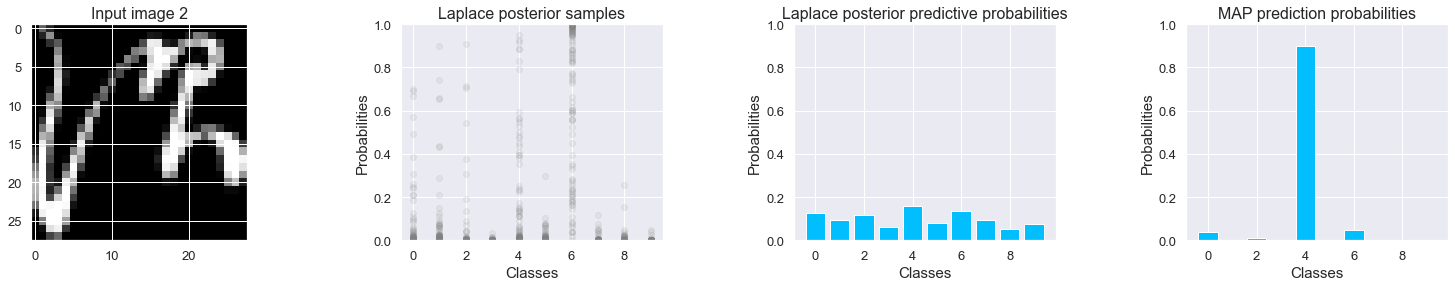

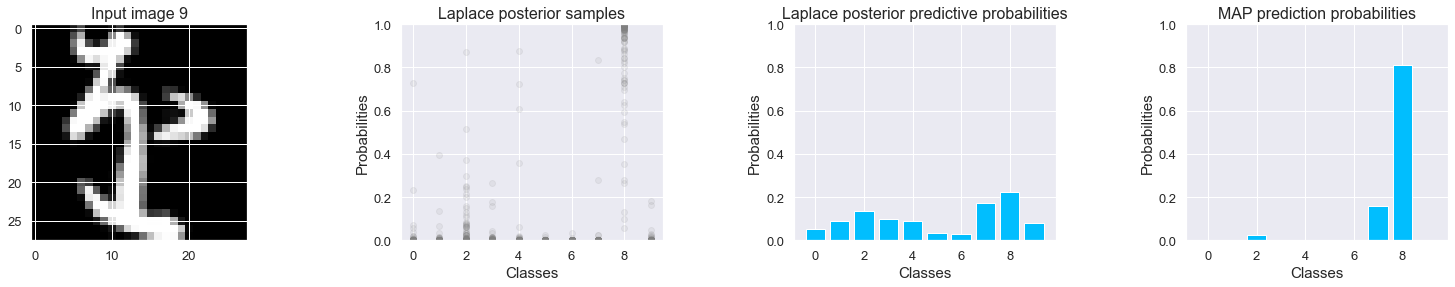

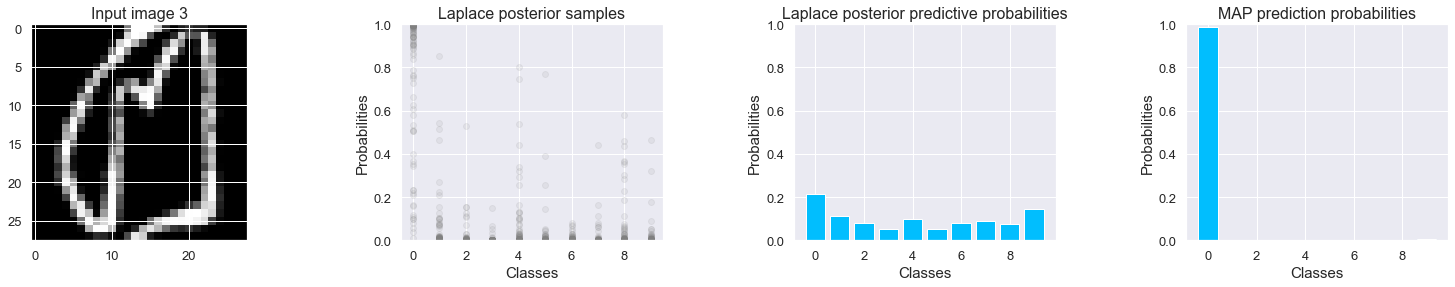

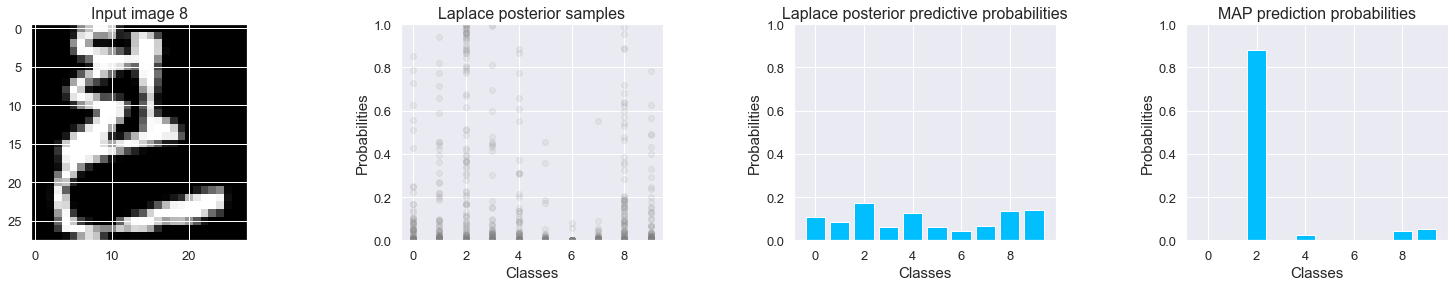

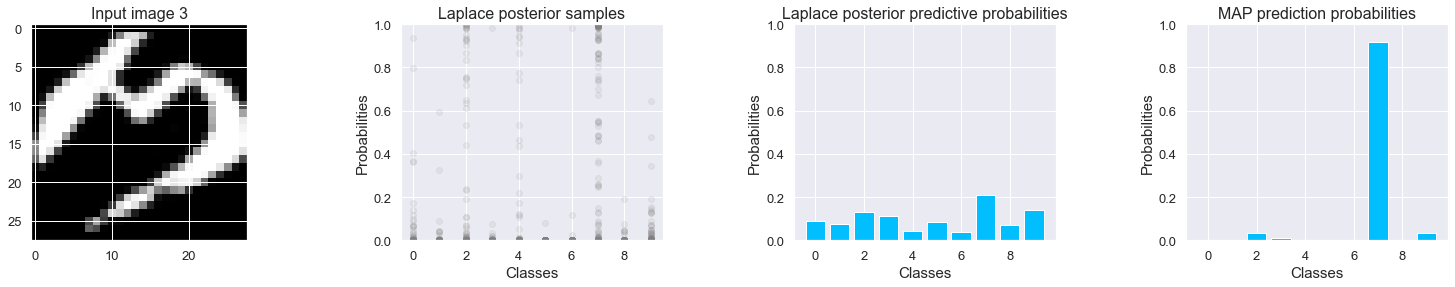

In [34]:
visualization.visualise_samples(ood_images,loader,test_ood,labels_ood,preds_ood,sub_la_images_ood,map_images_ood)

# Calibration Uncertainty

In [32]:
from src.utils.temperature_scaling import ModelWithTemperature
from src.utils import reliability_diagram


In [55]:
scaled_model = ModelWithTemperature(sub_la)
scaled_model.set_temperature(valid_loader)

Before temperature - NLL: 1.595, ECE: 0.141
Optimal temperature: 1.328
After temperature - NLL: 1.761, ECE: 0.351


ModelWithTemperature()

In [33]:
y_true = labels.cpu().detach().numpy()
_,y_pred= torch.max(map_images,-1)
y_conf = map_images.cpu().detach().numpy()

In [34]:
_,y_pred_la = torch.max(sub_la_images,-1)
y_conf_la = sub_la_images.cpu().detach().numpy()

In [35]:
labels_encoded = torch.nn.functional.one_hot(labels, num_classes=10)

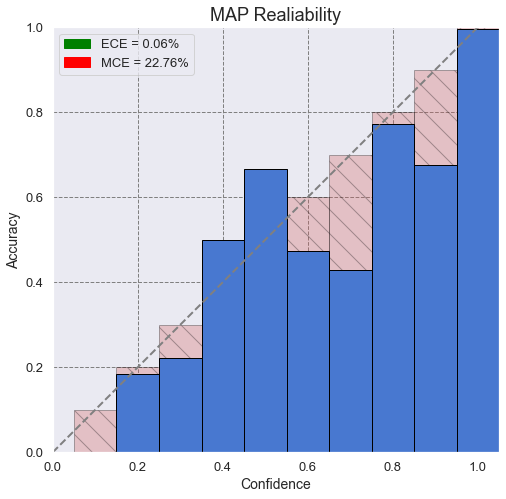

In [36]:
diagram = reliability_diagram.diagrams(y_conf,y_conf_la,labels_encoded,title='MAP Realiability')
diagram.draw_reliability_graph(y_conf,labels_encoded,title='MAP Realiability')

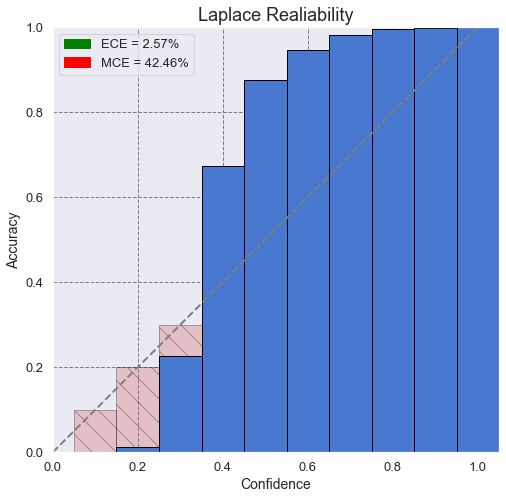

In [37]:
diagram.draw_reliability_graph(y_conf_la,labels_encoded,title='Laplace Realiability')

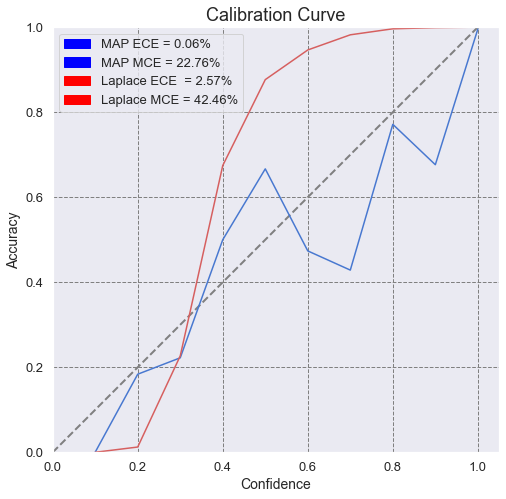

In [38]:
diagram.draw_calibration_graph(y_conf,y_conf_la,labels_encoded,title='Calibration Curve')

# Subsets Mnist

In [9]:
Subsets ={'100':'/Users/georgioszefkilis/Bayesian_Deep_Learning/saved_models/STN_MNIST_100_CPU.pth',
          '500':'/Users/georgioszefkilis/Bayesian_Deep_Learning/saved_models/STN_MNIST_500_CPU.pth',
          '2K':'/Users/georgioszefkilis/Bayesian_Deep_Learning/saved_models/STN_MNIST_2K_CPU.pth',
          '5K':'/Users/georgioszefkilis/Bayesian_Deep_Learning/saved_models/STN_MNIST_5K_CPU.pth',
          '10K':'/Users/georgioszefkilis/Bayesian_Deep_Learning/saved_models/STN_MNIST_10K_CPU.pth'}

In [10]:
map_acc = []
map_nll = []
map_ece =[]
subnetwork_acc = []
subnetwork_nll = []
subnetwork_ece = []
optimized_prior = []
for keys,values in Subsets.items():

    if keys == '100':

        print(keys)
        train_subset = 10

    elif keys == '500':

        print(keys)
        train_subset = 50

    elif keys == '2K':

        print(keys)
        train_subset = 200

    elif keys == '5K':

        print(keys)
        train_subset = 500

    elif keys == '10K':

        print(keys)
        train_subset = 1000

    model_path = values
    checkpoint = torch.load(model_path, map_location=device)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint["state_dict"])
    train_loader,valid_loader,test_loader = make_dataset.data(config["batch_size"],config["crop_size"],train_subset =train_subset,misplacement=False,load=True,save=False,subset=True)
    sub_la,_ = laplace_checks.laplace(model,train_loader,method = 'sub',module=['stn.fc_loc.0'])
    acc_map,ece_map,nll_map,map_images,labels = laplace_checks.predict(test_loader,model,laplace=False)
    # map_acc.append(acc_map)
    # map_nll.append(nll_map)
    # map_ece.append(ece_map)
    
    
    # prior_pre = [0.1,0.5,1,5,10,15]
    # for i in range(len(prior_pre)):
    #     sub_la.prior_precision = prior_pre[i]
    #     acc_sub,ece_sub,nll_sub,sub_la_images,_ = laplace_checks.predict(valid_loader,sub_la,laplace=True)
        
    #     subnetwork_acc.append(acc_sub)
    #     subnetwork_ece.append(ece_sub)
    #     subnetwork_nll.append(nll_sub)
        # print(
        #     f"[Sub Network Laplace] Acc.: {acc_sub:.1%}; ECE: {ece_sub:.1%}; NLL: {nll_sub:.3}"
        # )
        
    sub_la.optimize_prior_precision(method='marglik')
    optimized_prior.append(sub_la.prior_precision)
    
    acc_sub,ece_sub,nll_sub,sub_la_images,_ = laplace_checks.predict(test_loader,sub_la,laplace=True)

    map_acc.append(acc_map)
    map_nll.append(nll_map)
    map_ece.append(ece_map)
    
    subnetwork_acc.append(acc_sub)
    subnetwork_ece.append(ece_sub)
    subnetwork_nll.append(nll_sub)




100
Getting MNIST
Train_data 100
Validation_data 17970
Test_data 10000
500
Getting MNIST
Train_data 500
Validation_data 17850
Test_data 10000


KeyboardInterrupt: 

In [96]:
subnetwork_acc

[tensor(0.6667),
 tensor(0.6667),
 tensor(0.6667),
 tensor(0.6667),
 tensor(0.6667),
 tensor(0.6667),
 tensor(0.9400),
 tensor(0.9533),
 tensor(0.9533),
 tensor(0.9200),
 tensor(0.9067),
 tensor(0.9067),
 tensor(0.9400),
 tensor(0.9450),
 tensor(0.9467),
 tensor(0.9533),
 tensor(0.9533),
 tensor(0.9533),
 tensor(0.9567),
 tensor(0.9593),
 tensor(0.9600),
 tensor(0.9653),
 tensor(0.9680),
 tensor(0.9680),
 tensor(0.9717),
 tensor(0.9720),
 tensor(0.9727),
 tensor(0.9750),
 tensor(0.9773),
 tensor(0.9777)]

In [128]:
subnetwork_acc.index(max(subnetwork_acc[i:i+3])))result = [(max(subnetwork_acc[i:i+3]), for i in range(0, len(subnetwork_acc), 3)]

In [129]:
result

[(tensor(0.6667), 0),
 (tensor(0.6667), 0),
 (tensor(0.9533), 7),
 (tensor(0.9200), 9),
 (tensor(0.9467), 14),
 (tensor(0.9533), 7),
 (tensor(0.9600), 20),
 (tensor(0.9680), 22),
 (tensor(0.9727), 26),
 (tensor(0.9777), 29)]

In [143]:
result = [subnetwork_nll[i:i+len(prior_pre)] for i in range(0, len(subnetwork_nll), len(prior_pre))]
max_idx = [(min(result[i]),prior_pre[result[i].index(min(result[i]))]) for i in range(len(result))]
max_idx

[(tensor(1.8142), 15),
 (tensor(0.3844), 15),
 (tensor(0.1436), 15),
 (tensor(0.1035), 15),
 (tensor(0.0789), 15)]

In [105]:
map_acc

[tensor(0.5573),
 tensor(0.9210),
 tensor(0.9687),
 tensor(0.9781),
 tensor(0.9823)]

In [111]:
for k in range(len(prior_pre)):
    c = [subnetwork_acc[i]  for i in range(k, len(subnetwork_acc), len(prior_pre))]
    print(c)

[tensor(0.6667), tensor(0.9400), tensor(0.9400), tensor(0.9567), tensor(0.9717)]
[tensor(0.6667), tensor(0.9533), tensor(0.9450), tensor(0.9593), tensor(0.9720)]
[tensor(0.6667), tensor(0.9533), tensor(0.9467), tensor(0.9600), tensor(0.9727)]
[tensor(0.6667), tensor(0.9200), tensor(0.9533), tensor(0.9653), tensor(0.9750)]
[tensor(0.6667), tensor(0.9067), tensor(0.9533), tensor(0.9680), tensor(0.9773)]
[tensor(0.6667), tensor(0.9067), tensor(0.9533), tensor(0.9680), tensor(0.9777)]


In [203]:
sub_acc = [subnetwork_acc[i:i+len(prior_pre)] for i in range(0, len(subnetwork_acc), len(prior_pre))]
sub_ece = [subnetwork_ece[i:i+len(prior_pre)] for i in range(0, len(subnetwork_ece), len(prior_pre))]
sub_nll = [subnetwork_nll[i:i+len(prior_pre)] for i in range(0, len(subnetwork_nll), len(prior_pre))]
max_idx_acc = max([(max(sub_acc[i]),prior_pre[sub_acc[i].index(max(sub_acc[i]))]) for i in range(len(sub_acc))])
min_idx_ece = min([(min(sub_ece[i]),prior_pre[sub_ece[i].index(min(sub_ece[i]))]) for i in range(len(sub_ece))])
min_idx_nll = min([(min(sub_nll[i]),prior_pre[sub_nll[i].index(min(sub_nll[i]))]) for i in range(len(sub_nll))])

if (max_idx_acc[1] == min_idx_ece[1]==min_idx_nll[1]):
    print('optimal prior precision',max_idx_acc[1])
else:
    print('optimal prior precision',min_idx_ece[1])


optimal prior precision 15


In [201]:
max_idx_acc[1]

15

optimal prior precision along all metrics 15


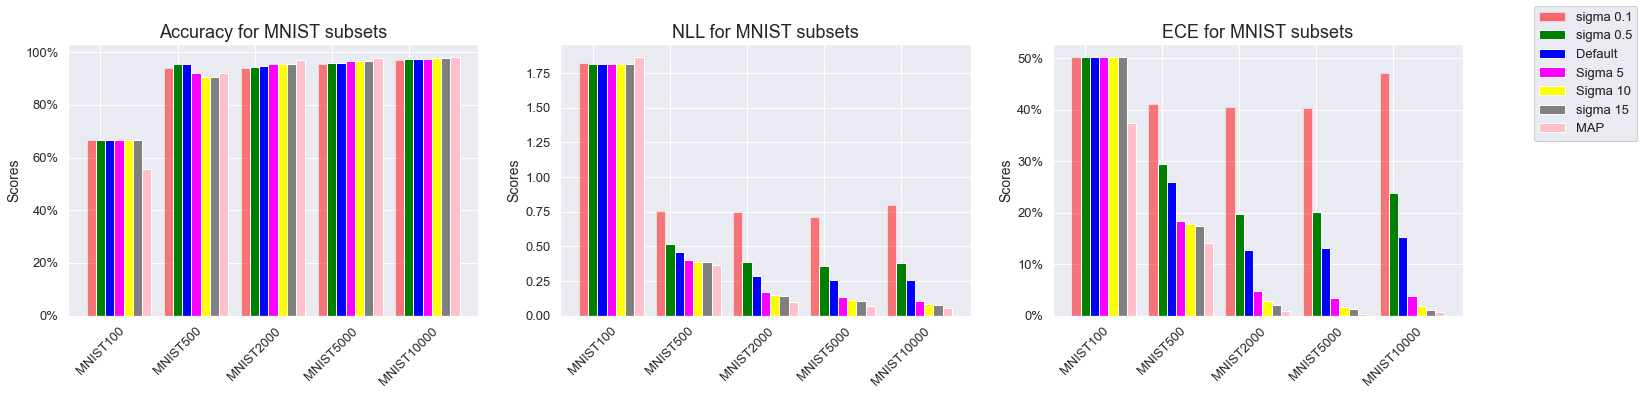

In [206]:

sub_acc = [subnetwork_acc[i:i+len(prior_pre)] for i in range(0, len(subnetwork_acc), len(prior_pre))]
sub_ece = [subnetwork_ece[i:i+len(prior_pre)] for i in range(0, len(subnetwork_ece), len(prior_pre))]
sub_nll = [subnetwork_nll[i:i+len(prior_pre)] for i in range(0, len(subnetwork_nll), len(prior_pre))]
max_idx_acc = max([(max(sub_acc[i]),prior_pre[sub_acc[i].index(max(sub_acc[i]))]) for i in range(len(sub_acc))])
min_idx_ece = min([(min(sub_ece[i]),prior_pre[sub_ece[i].index(min(sub_ece[i]))]) for i in range(len(sub_ece))])
min_idx_nll = min([(min(sub_nll[i]),prior_pre[sub_nll[i].index(min(sub_nll[i]))]) for i in range(len(sub_nll))])

if (max_idx_acc[1] == min_idx_ece[1]==min_idx_nll[1]):
    print('optimal prior precision along all metrics',max_idx_acc[1])
else:
    print('optimal prior precision minimum ECE',min_idx_ece[1])


N = len(Subsets)
ind = np.arange(N)  # the x locations for the groups
width = 0.12       # the width of the bars

metrics_sub = [subnetwork_acc,subnetwork_nll,subnetwork_ece]
metrics_map = [map_acc,map_nll,map_ece]
fig,ax = plt.subplots(1,3,figsize=(25,5))


for j in range(len(metrics_sub)):
    
    yvals =[metrics_sub[j][i]  for i in range(0, len(metrics_sub[j]), len(prior_pre))]
    
    zvals = [metrics_sub[j][i+1]  for i in range(0, len(metrics_sub[j]), len(prior_pre))]
    kvals = [metrics_sub[j][i+2]  for i in range(0, len(metrics_sub[j]), len(prior_pre))]
    tvals = [metrics_sub[j][i+3]  for i in range(0, len(metrics_sub[j]), len(prior_pre))]
    mvals = [metrics_sub[j][i+4]  for i in range(0, len(metrics_sub[j]), len(prior_pre))]
    nvals = [metrics_sub[j][i+5]  for i in range(0, len(metrics_sub[j]), len(prior_pre))]


    pvals = [metrics_map[j][i]  for i in range(0, len(metrics_map[j]))]


    rects1 = ax[j].bar(ind, yvals, width,color='red',alpha=0.5)
    rects2 = ax[j].bar(ind+width, zvals, width, color='green')
    rects3 = ax[j].bar(ind+width*2, kvals, width, color='blue')
    rects4 = ax[j].bar(ind+width*3, tvals, width, color='magenta')
    rects5 = ax[j].bar(ind+width*4, mvals, width, color='yellow')
    rects6 = ax[j].bar(ind+width*5, nvals, width, color='grey')

    rects7 = ax[j].bar(ind+width*6, pvals, width, color='pink')

    acc = ax[0].get_yticks()
    ax[0].set_yticklabels(['{:,.0%}'.format(x) for x in acc])
    ece = ax[2].get_yticks()
    ax[2].set_yticklabels(['{:,.0%}'.format(x) for x in ece])


    ax[j].set_ylabel('Scores')
    ax[j].set_xticks(ind+width)
    ax[j].set_xticklabels( ('MNIST100', 'MNIST500', 'MNIST2000','MNIST5000','MNIST10000'),rotation=45 )
    fig.legend( (rects1[0], rects2[0], rects3[0],rects4[0],rects5[0],rects6[0],rects7[0]), ('sigma 0.1', 'sigma 0.5', 'Default','Sigma 5','Sigma 10','sigma 15','MAP'),loc = 'upper right' )
    # ax[j].legend( (rects1[0], rects1[1], rects1[2],rects1[3],rects1[4],rects4[0]), ('sigma 0.1', 'sigma 0.5', 'Default','Sigma 10','Sigma 30','MAP') )

    #titles
    ax[0].set_title('Accuracy for MNIST subsets')
    ax[1].set_title('NLL for MNIST subsets')
    ax[2].set_title('ECE for MNIST subsets')
    

plt.show()





In [49]:
import pandas as pd

In [50]:
subset_data = {
    'MAP 100':[f'{map_acc[0]:.1%}',f'{map_ece[0]:.1%}',f'{map_nll[0]:.3}'],
    'Laplace 100':[f'{subnetwork_acc[0]:.1%}',f'{subnetwork_ece[0]:.1%}',f'{subnetwork_nll[0]:.3}'],
    'MAP 500':[f'{map_acc[1]:.1%}',f'{map_ece[1]:.1%}',f'{map_nll[1]:.3}'],
    'Laplace 500':[f'{subnetwork_acc[1]:.1%}',f'{subnetwork_ece[1]:.1%}',f'{subnetwork_nll[1]:.3}'],
    'MAP 2K':[f'{map_acc[2]:.1%}',f'{map_ece[2]:.1%}',f'{map_nll[2]:.3}'],
    'Laplace 2K':[f'{subnetwork_acc[2]:.1%}',f'{subnetwork_ece[2]:.1%}',f'{subnetwork_nll[2]:.3}'],
    'MAP 5K':[f'{map_acc[3]:.1%}',f'{map_ece[3]:.1%}',f'{map_nll[3]:.3}'],
    'Laplace 5K':[f'{subnetwork_acc[3]:.1%}',f'{subnetwork_ece[3]:.1%}',f'{subnetwork_nll[3]:.3}'],
    'MAP 10K':[f'{map_acc[4]:.1%}',f'{map_ece[4]:.1%}',f'{map_nll[4]:.3}'],
    'Laplace 10K':[f'{subnetwork_acc[4]:.1%}',f'{subnetwork_ece[4]:.1%}',f'{subnetwork_nll[4]:.3}']
    }
indices = ['Acc','ECE','NLL']
laplace_report = pd.DataFrame(subset_data,index=indices)
laplace_report

,MAP 100,Laplace 100,MAP 500,Laplace 500,MAP 2K,Laplace 2K,MAP 5K,Laplace 5K,MAP 10K,Laplace 10K
Acc,55.7%,55.7%,92.1%,92.2%,96.9%,96.8%,97.8%,97.7%,98.2%,98.2%
ECE,37.5%,37.5%,14.1%,14.5%,0.9%,1.7%,0.3%,0.7%,0.7%,0.5%
NLL,1.87,1.87,0.367,0.371,0.1,0.108,0.0686,0.0756,0.0582,0.059


In [53]:
import matplotlib.ticker as mtick


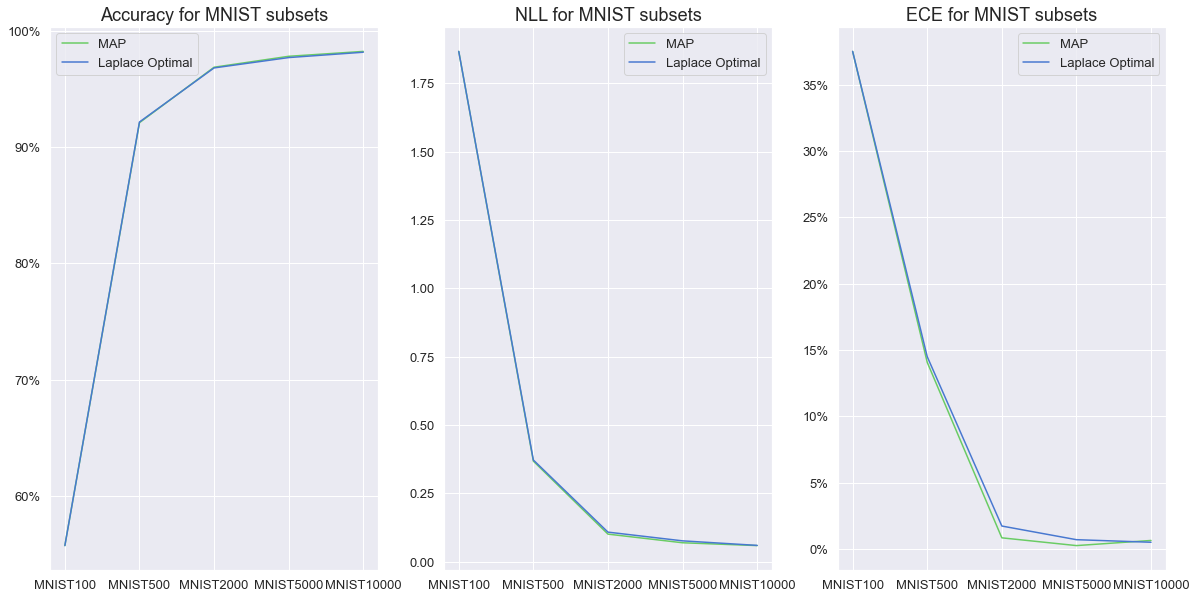

In [54]:
fig,ax = plt.subplots(1,3,figsize=(20,10))

#plots
ax[0].plot(map_acc,color = 'g',label = 'MAP')
ax[0].plot(subnetwork_acc,color='b',label = 'Laplace Optimal')
ax[1].plot(map_nll,color = 'g',label = 'MAP')
ax[1].plot(subnetwork_nll,color='b',label = 'Laplace Optimal')
ax[2].plot(map_ece,color = 'g',label = 'MAP')
ax[2].plot(subnetwork_ece,color='b',label = 'Laplace Optimal')
acc = ax[0].get_yticks()
ax[0].set_yticklabels(['{:,.0%}'.format(x) for x in acc])
ece = ax[2].get_yticks()
ax[2].set_yticklabels(['{:,.0%}'.format(x) for x in ece])

#titles
ax[0].set_title('Accuracy for MNIST subsets')
ax[1].set_title('NLL for MNIST subsets')
ax[2].set_title('ECE for MNIST subsets')


#legends
ax[0].legend()
ax[1].legend()
ax[2].legend()

#xlabels
labels = [item.get_text() for item in ax[0].get_xticklabels()]
labels[1] = 'MNIST100'
labels[2] = 'MNIST500'
labels[3] = 'MNIST2000'
labels[4] = 'MNIST5000'
labels[5] = 'MNIST10000'

ax[0].set_xticklabels(labels)
ax[1].set_xticklabels(labels)
ax[2].set_xticklabels(labels)


plt.show()

# Continue training experiment

In [220]:
from torch import nn, optim
from src.models import Hyperparameters as hp

In [208]:
model_path='/Users/georgioszefkilis/Bayesian_Deep_Learning/saved_models/STN_MNIST_100_CPU.pth'

In [212]:
train_loader,valid_loader,test_loader = make_dataset.data(config["batch_size"],config["crop_size"],train_subset=10,misplacement=False,load=True,save=False,subset=True)

Getting MNIST
Train_data 100
Validation_data 17970
Test_data 10000


In [213]:
[ (name,np.prod(p.size())) for name,p in model.named_parameters() if p.requires_grad]

[('base.base_net.0.0.weight', 400),
 ('base.base_net.0.0.bias', 16),
 ('base.base_net.0.2.weight', 16),
 ('base.base_net.0.2.bias', 16),
 ('base.base_net.1.0.weight', 12800),
 ('base.base_net.1.0.bias', 32),
 ('base.base_net.1.2.weight', 32),
 ('base.base_net.1.2.bias', 32),
 ('stn.localization.0.0.weight', 200),
 ('stn.localization.0.0.bias', 8),
 ('stn.localization.0.2.weight', 8),
 ('stn.localization.0.2.bias', 8),
 ('stn.localization.1.0.weight', 2000),
 ('stn.localization.1.0.bias', 10),
 ('stn.localization.1.2.weight', 10),
 ('stn.localization.1.2.bias', 10),
 ('stn.fc_loc.0.weight', 5120),
 ('stn.fc_loc.0.bias', 32),
 ('stn.fc_loc.2.weight', 192),
 ('stn.fc_loc.2.bias', 6),
 ('fc1.weight', 25600),
 ('fc1.bias', 50),
 ('fc2.weight', 500),
 ('fc2.bias', 10)]

In [67]:
checkpoint = torch.load(model_path, map_location=device)
    # initialize state_dict from checkpoint to model
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [221]:
model.stn.fc_loc[0].weight.requires_grad =False
model.stn.fc_loc[2].weight.requires_grad =False
model.stn.localization[0][0].weight.requires_grad = False
model.stn.localization[0][2].weight.requires_grad = False
model.stn.localization[1][0].weight.requires_grad = False
model.stn.localization[1][2].weight.requires_grad = False

In [222]:
# optimizer = optim.Adam([
#                 {'params': model.base.parameters()},
#                 {'params':model.fc1.parameters()},
#                 {'params':model.fc2.parameters()},
                
#             ], lr=config["learning_rate_base"])

criterion = nn.CrossEntropyLoss()

In [223]:
optimizer = optim.Adam([
                {'params': model.base.parameters()},
                {'params':model.fc1.parameters()},
                {'params':model.fc2.parameters()},
                {'params':model.stn.fc_loc.parameters(),'lr': config["learning_rate_stn"]},
                {'params': model.stn.localization.parameters(), 'lr': config["learning_rate_stn"]}
            ], lr=config["learning_rate_base"])

In [ ]:
optimizer.load_state_dict(checkpoint['optimizer'])

In [224]:
model,optimizer,start_eposh,valid_loss_min = SaveLoad.load_ckp(model_path,model,optimizer,device)

In [225]:
print(start_eposh)

11


In [226]:
print(valid_loss_min)

0.0662025014559428


In [227]:
start_epoch = checkpoint['epoch']
valid_loss_pre = valid_loss_min
sub_la.prior_precision=15
for epoch in range(start_epoch, 15 + 1):
    
    train_loss = 0
    model.train()
    #new_data = []
    #new_target_set = []
    for batch_idx, (data, target) in enumerate(train_loader):
        #print(batch_idx)
        data, target = data.to(device), target.to(device)
        # print(data.shape)
        #new_data.append(data)
        #new_target_set.append(target)
        subnet_samples = sub_la.sample(n_samples=10)
        transformation = []
        for sample in subnet_samples:
            torch.nn.utils.vector_to_parameters(sample, model.parameters())
            transformed_input_tensor = model.stn(data.to(device))
            transformation.append(transformed_input_tensor)
        # print('transformation shape',transformation[0].shape)
        #new_target_set.append(target)
        #new_data.append(transformed_input_tensor)
        data = torch.cat((data,transformed_input_tensor))
        target = torch.cat((target,target))
        # print('data_shape',data.shape)
        # print('target_shape',target.shape)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if batch_idx % 500 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item(),
                )
            )
    with torch.no_grad():
            model.eval()
            test_loss = 0
            correct = 0

            for data, target in valid_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)

                # sum up batch loss
                test_loss += criterion(output, target).item()
                # get the index of the max log-probability
                pred = output.max(1, keepdim=True)[1]
                correct += pred.eq(target.view_as(pred)).sum().item()

            test_loss /= len(test_loader.dataset)

            
            print(
                "\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
                    test_loss,
                    correct,
                    len(valid_loader.dataset),
                    100.0 * correct / len(valid_loader.dataset),
                )
            )

            if test_loss <= valid_loss_min:
                print(
                    "Validation loss decreased ({:.6f} --> {:.6f})".format(
                        valid_loss_min, test_loss
                    )
                )

Train Epoch: 11 [0/100 (0%)]	Loss: 1.762135

Test set: Average loss: 0.0184, Accuracy: 5720/10000 (57%)

Validation loss decreased (0.066203 --> 0.018390)
Train Epoch: 12 [0/100 (0%)]	Loss: 1.821575

Test set: Average loss: 0.0182, Accuracy: 5830/10000 (58%)

Validation loss decreased (0.066203 --> 0.018212)
Train Epoch: 13 [0/100 (0%)]	Loss: 1.765056

Test set: Average loss: 0.0181, Accuracy: 5917/10000 (59%)

Validation loss decreased (0.066203 --> 0.018076)
Train Epoch: 14 [0/100 (0%)]	Loss: 1.767363

Test set: Average loss: 0.0178, Accuracy: 5919/10000 (59%)

Validation loss decreased (0.066203 --> 0.017849)
Train Epoch: 15 [0/100 (0%)]	Loss: 1.772163

Test set: Average loss: 0.0177, Accuracy: 6027/10000 (60%)

Validation loss decreased (0.066203 --> 0.017728)


In [261]:
sub_la.optimize_prior_precision(method='marglik',val_loader=valid_loader)

In [262]:
sub_la.prior_precision

tensor([0.0516])

In [263]:
acc_sub,ece_sub,nll_sub,sub_la_images,_ = laplace_checks.predict(test_loader,sub_la,laplace=True)
print(
        f"[Sub Network Laplace] Acc.: {acc_sub:.1%}; ECE: {ece_sub:.1%}; NLL: {nll_sub:.3}"
    )

[Sub Network Laplace] Acc.: 60.1%; ECE: 40.7%; NLL: 1.8
